In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://cedar.openmadrigal.org/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2011,8,4,0,0,0)
et=datetime.datetime(2011,8,5,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 100020043
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100020043
url: http://cedar.openmadrigal.org/madtoc/experiments/2011/pfa/01aug11a
name: MSWinds23 - D-region E-region F-region local measurements
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2011
startmonth: 8
startday: 1
starthour: 0
startmin: 5
startsec: 1
endyear: 2011
endmonth: 8
endday: 5
endhour: 22
endmin: 26
endsec: 27
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1543545544
access: 2
Madrigal version: 3.0



In [5]:
fileList = maddat.getExperimentFiles(expList[0].id)
acfile=None
for file in fileList:
    if re.match('Alternating Code \(AC16-30\)',file.kindatdesc):
        acfile=file
        
filename=acfile.name
outfilename=acfile.name.split('/')[-1]
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [6]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [7]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

64016.0 14.04 90.0
64157.0 -154.3 77.5
64964.0 -34.69 66.09
65066.0 75.03 65.56


In [8]:
#find the vertical beam
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==90.0:
        bind=i
bdat=PFISR_data[bind]

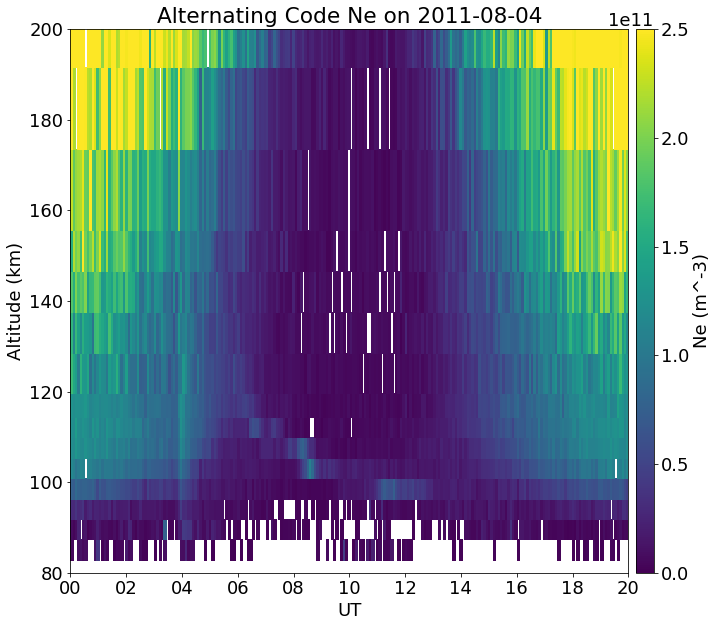

In [9]:
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,ax=plt.subplots(1,1)
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2.5e11)

ax.set_xlim([mdates.date2num(datetime.datetime(2011,8,4,0,0,0)),mdates.date2num(datetime.datetime(2011,8,4,20,0,0))])
ax.set_xticks(np.arange(mdates.date2num(datetime.datetime(2011,8,4,0,0,0)),mdates.date2num(datetime.datetime(2011,8,4,22,0,0)),2/24.0))
ax.set_ylim([80,200])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Alternating Code Ne on 2011-08-04')

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m^-3)')

In [10]:
a115=np.argmin(np.abs(bdat['altitude']-115.0))
bdat['altitude'][a115]

114.27

Text(0.5, 0, 'UT')

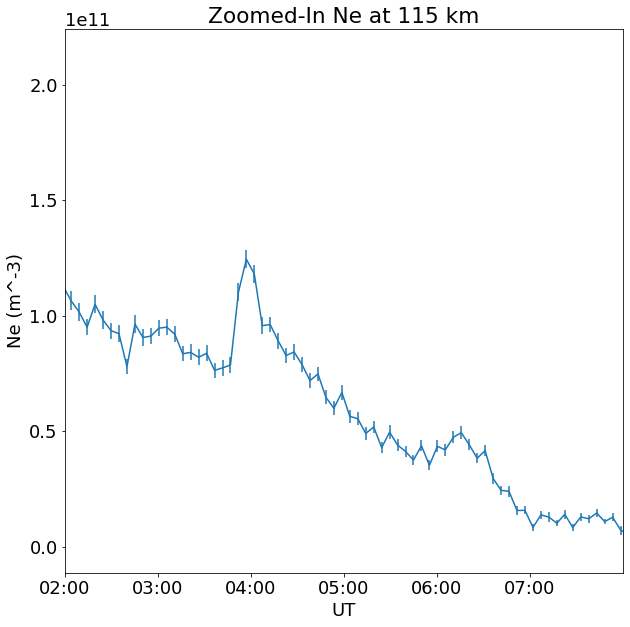

In [11]:
fig,ax=plt.subplots(1,1)    
ax.errorbar(mdates.date2num(bdat['time']),bdat['ne'][a115,:],yerr=bdat['dne'][a115,:])
ax.set_xlim([mdates.date2num(datetime.datetime(2011,8,4,2,0,0)),mdates.date2num(datetime.datetime(2011,8,4,8,0,0))])
ax.set_xticks(np.arange(mdates.date2num(datetime.datetime(2011,8,4,2,0,0)),mdates.date2num(datetime.datetime(2011,8,4,8,0,0)),1.00001/24.0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('Zoomed-In Ne at 115 km')
ax.set_ylabel('Ne (m^-3)')
ax.set_xlabel('UT')

Hints: GOES X-ray data
ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/
ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/2011_plots/2011_xray.tar.gz
ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/2011_events.tar.gz